In [16]:
import numpy as np
import matplotlib.pyplot as plt
import rawpy
from scipy.signal import convolve2d
import os
import imageio
from skimage import io, img_as_float,restoration

In [10]:
x = np.load('IMG_9939.npy')
print('Loaded array of size', x.shape)
print('The pens, from top to bottom, are red, green and blue')

Loaded array of size (4014, 6020)
The pens, from top to bottom, are red, green and blue


In [ ]:
# new_arr = ((x - x.min()) * (1/(x.max() - x.min()) * 255)).astype('uint8')

In [ ]:
# plt.imshow(new_arr)

In [ ]:
# np.min(new_arr)

task 1

In [12]:
def identify_bayer_pattern_from_data(x):
    patterns = {
        "C1": "RGGB",
        "C2": "GRBG",
        "C3": "GBRG",
        "C4": "BGGR"
    }

    # Assuming data is a 2D array representing image sensor data
    # height, width = len(x), len(x[0])
    sample = np.array([x[i][:2] for i in range(2)]).flatten()

    #Count occurrences of red, blue, and green pixels
    red_count = np.sum(sample[::2])
    blue_count = np.sum(sample[1::2])
    green_count = np.sum(sample[1:-1:2])

    if red_count > blue_count and red_count > green_count:
        return patterns["C1"]
    elif blue_count > red_count and blue_count > green_count:
        return patterns["C4"]
    elif green_count > red_count and green_count > blue_count:
        return patterns["C2"]
    else:
        return patterns["C3"]


# Assuming 'image_data' is your raw image data
identified_pattern = identify_bayer_pattern_from_data(x)
print(f"The identified Bayer pattern is: {identified_pattern}")


The identified Bayer pattern is: RGGB


#** task 2 **#

In [24]:
# Folder containing image files
folder_path = '/Users/pankajrathi/Projcv/exercise2/exercise_2_data/02'
image_files = ['IMG_3044.CR3', 'IMG_3045.CR3', 'IMG_3046.CR3', 'IMG_3047.CR3', 'IMG_3048.CR3', 'IMG_3049.CR3']

# Get a list of all files in the folder
image_files = [os.path.join(folder_path, file) for file in image_files]


# Exposure times in seconds
exposure_times = [1/10, 1/20, 1/40, 1/80, 1/160, 1/320]


In [25]:
# Arrays to store average pixel values
avg_red = []
avg_green = []
avg_blue = []

# Loop through each image
for file in image_files:
    # Read raw sensor data
    raw = rawpy.imread(file)
    array = np.array(raw.raw_image_visible)

    # Calculate average pixel values
    avg_red.append(np.mean(array[::2, ::2]))  # Red pixels
    avg_green.append(np.mean(array[1::2, ::2] + array[::2, 1::2]) / 2)  # Green pixels
    avg_blue.append(np.mean(array[1::2, 1::2]))  # Blue pixels

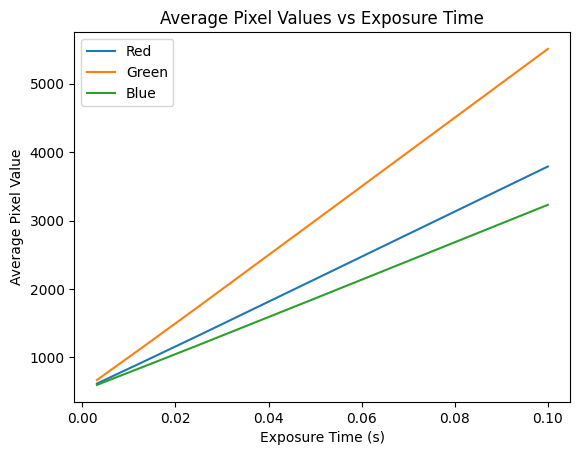

In [27]:
# Plotting
plt.plot(exposure_times, avg_red, label='Red')
plt.plot(exposure_times, avg_green, label='Green')
plt.plot(exposure_times, avg_blue, label='Blue')
# Set plot labels and title
plt.xlabel('Exposure Time (s)')
plt.ylabel('Average Pixel Value')
plt.title('Average Pixel Values vs Exposure Time')
plt.legend()
plt.xscale('log')  # Use logarithmic scale for exposure time

# Display the plot
plt.show()

"* task 3 *"

In [29]:
# Load the CR3 image #/Users/pankajrathi/Projcv/exercise_2_data/06/00.CR3## #03/IMG_4782.CR3   /Users/pankajrathi/Projcv/exercise_2_data/02/IMG_3044.CR3
raw_data = rawpy.imread('/Users/pankajrathi/Projcv/exercise2/exercise_2_data/03/IMG_4782.CR3')
image_data = raw_data.raw_image_visible.astype('uint16')  # Assuming 16-bit data

# Identify the Bayer pattern
identified_pattern = identify_bayer_pattern_from_data(image_data)

print(f"The identified Bayer pattern is: {identified_pattern}")

The identified Bayer pattern is: RGGB


In [30]:
image_data.shape

(4660, 6984)

In [31]:
def encode_14bit_to_8bit(data_14bit):
    # Assuming data_14bit is a NumPy array or a list containing 14-bit data
    max_14bit_value = 2**14 - 1  # Maximum value for 14-bit data
    scale_factor = 255 / max_14bit_value

    # Linear scaling to the range [0, 255]
    encoded_data_8bit = (data_14bit * scale_factor).astype(int)

    return encoded_data_8bit

In [32]:
image_data_14bit = encode_14bit_to_8bit(image_data)

In [33]:
# Identify the Bayer pattern
identified_pattern = identify_bayer_pattern_from_data(image_data_14bit)

print(f"The identified Bayer pattern is: {identified_pattern}")

The identified Bayer pattern is: RGGB


In [34]:
def bayer(im):
    r = np.zeros(im.shape[:2])
    g = np.zeros(im.shape[:2])
    b = np.zeros(im.shape[:2])
    r[0::2, 0::2] += im[0::2, 0::2]
    g[0::2, 1::2] += im[0::2, 1::2]
    g[1::2, 0::2] += im[1::2, 0::2]
    b[1::2, 1::2] += im[1::2, 1::2]
    return r, g, b

In [104]:
def bilinear(im):
    r, g, b = bayer(im)


    # Define kernels
    k = 1/9 * np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]])
    # k_r = 1/4 * np.array([[1, 0, 1], [0, 0, 0], [1, 0, 1]])
    # k_b = 1/4 * np.array([[1, 0, 1], [0, 0, 0], [1, 0, 1]])

    # Create masks for pixels where each channel is greater than zero
    mask_r = (r > 0).astype(np.float32)
    mask_g = (g > 0).astype(np.float32)
    mask_b = (b > 0).astype(np.float32)

    # Compute the weighted sum for each channel
    weighted_sum_r = convolve2d(mask_r * r, k, 'same')
    weighted_sum_g = convolve2d(mask_g * g, k, 'same')
    weighted_sum_b = convolve2d(mask_b * b, k, 'same')

    # Compute the weighted average for each channel
    weighted_average_r = np.maximum(convolve2d(mask_r, k, 'same'), 1.0)
    weighted_average_g = np.maximum(convolve2d(mask_g, k, 'same'), 1.0)
    weighted_average_b = np.maximum(convolve2d(mask_b, k, 'same'), 1.0)

    # Update each channel
    r = weighted_sum_r / weighted_average_r
    g = weighted_sum_g / weighted_average_g
    b = weighted_sum_b / weighted_average_b

    return r, g, b

In [101]:
bayer_r, bayer_g, bayer_b = bayer(image_data_14bit)
result_image_bayer = np.dstack([bayer_r, bayer_g, bayer_b])
result_image_bayer.shape

(4660, 6984, 3)

In [102]:
r, g, b = bilinear(image_data_14bit)
result_image = np.dstack([r, g, b])
result_image.shape

(4660, 6984, 3)

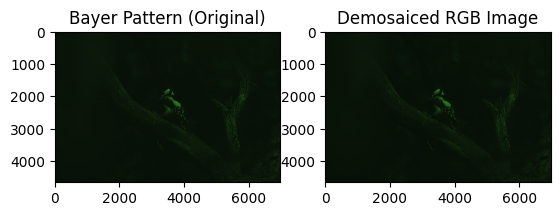

In [103]:
# Plot the original Bayer pattern image
plt.subplot(1, 2, 1)
plt.imshow(result_image_bayer.astype(np.uint8))
plt.title('Bayer Pattern (Original)')

# Plot the demosaiced RGB image
plt.subplot(1, 2, 2)
plt.imshow(result_image.astype(np.uint8))
plt.title('Demosaiced RGB Image')

plt.show()

task 4

In [98]:
gamma_value = 1 #hard-coded
def percentile_normalize(image_data):

    a = np.percentile(image_data, 0.01)
    b = np.percentile(image_data, 99.99)

    # Normalize to the range [0, 1] using min and max values
    normalized_data = (image_data - a)/(b-a)

    #range [0,1]
    normalized_data[normalized_data<0] = 0
    normalized_data[normalized_data>1] = 1

    # Apply gamma correction
    img_corrected = np.power(normalized_data , gamma_value)

    # Invert the transform to get back to the previous range of values
    img_corrected = (img_corrected * (b - a)) + a

    return img_corrected


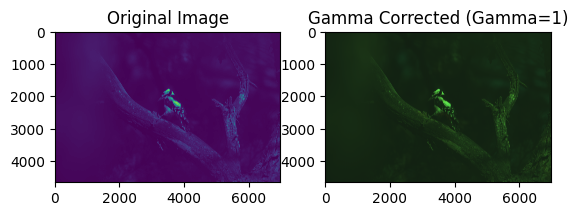

In [99]:
# Apply gamma correction
corrected_image = percentile_normalize(result_image)
#original image
normalized_image =percentile_normalize(image_data_14bit)

# Display the original and corrected images
plt.subplot(1, 2, 1)
plt.imshow(normalized_image.astype(np.uint8))
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(corrected_image.astype(np.uint8))
plt.title(f'Gamma Corrected (Gamma={gamma_value})')

plt.show()

task 5 (white balance)

In [41]:
# White balancing
def whitebalance(image_data):
    mean_image = np.mean(image_data)
    mean_red = np.mean(image_data[:, :, 0])
    mean_green = np.mean(image_data[:, :, 1])
    mean_blue = np.mean(image_data[:, :, 2])

    image_data[:, :, 0] = image_data[:, :, 0] * mean_image // mean_red
    image_data[:, :, 1] = image_data[:, :, 1] * mean_image // mean_green
    image_data[:, :, 2] = image_data[:, :, 2] * mean_image // mean_blue

    clipped_array = np.clip(image_data, 0, 255)
    return clipped_array

In [42]:
whitebalance_image = whitebalance(corrected_image)

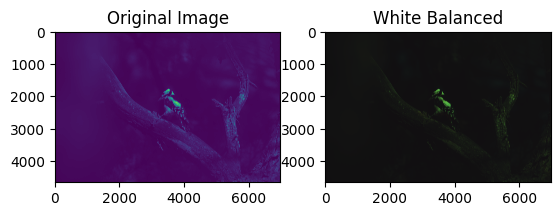

In [43]:
# Display the original and corrected images
plt.subplot(1, 2, 1)
plt.imshow(image_data_14bit.astype(np.uint8))
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(whitebalance_image.astype(np.uint8))
plt.title('White Balanced')

plt.show()

task 6 (HDR Image)

In [56]:
folder_path = '/Users/pankajrathi/Projcv/exercise2/exercise_2_data/06'
image_files = ['00.CR3', '01.CR3', '02.CR3', '03.CR3', '04.CR3', '05.CR3', '06.CR3', '07.CR3', '08.CR3', '09.CR3', '10.CR3']
image_files = [os.path.join(folder_path, file) for file in image_files]
brightest_path = '/Users/pankajrathi/Projcv/exercise2/exercise_2_data/06/00.CR3'

In [57]:
def combine_images(brightest_path, input_paths, threshold=0.8):
    # Load the brightest raw data (h)
    with rawpy.imread(brightest_path) as raw_brightest:
        h = raw_brightest.raw_image_visible.copy()

    exposure_factor = 2
    # Iterate through the rest of the raw files
    for input_path in input_paths:
        # Load the current raw file (i)
        with rawpy.imread(input_path) as raw_input:
            i = raw_input.raw_image_visible.copy()

        # Adjust i by the exposure factor
        i_adjusted = i * exposure_factor


        # Find values in h above the threshold
        mask = h > threshold * np.max(h)

        # Replace values in h with corresponding values in i_adjusted
        h[mask] = i_adjusted[mask]

        # Update exposure factor for the next iteration
        exposure_factor /= 2.0

    return h

In [58]:
combined_image = combine_images(brightest_path, image_files)

In [59]:
combined_image.shape

(4660, 6984)

In [60]:
def demosaiced_image(img):

    # Bilinear interpolation for demosaicing
    r, g, b = bilinear(img)
    demosaiced_image = np.dstack([r, g, b])
    # r,g,b = bilinear(img)
    # Apply white balance
    whitebalance_img = whitebalance(demosaiced_image)
    # # Log mean fusion (modify as needed)
    # hdr_image = decrease_dynamic_range(demosaiced_images)

    return whitebalance_img

In [61]:
hdr_image = demosaiced_image(combined_image)

In [62]:
hdr_image.shape

(4660, 6984, 3)

In [63]:
def decrease_dynamic_range(demosaiced_data):
    log_data = np.log1p(demosaiced_data)
    scaled_data = (255 * (log_data - np.min(log_data)) / np.ptp(log_data)).astype(np.uint8)
    return scaled_data

In [64]:
# Decrease dynamic range and scale to [0, 255]
scaled_hdr_data = decrease_dynamic_range(hdr_image)

In [65]:
scaled_hdr_data.shape

(4660, 6984, 3)

In [79]:
def plot_image(image_name, n_rows=1, n_colums=1 ,image_index=1 ,title="White Balanced"):
    plt.subplot(n_rows, n_colums, image_index)
    plt.imshow(image_name.astype(np.uint8))
    plt.title(title)

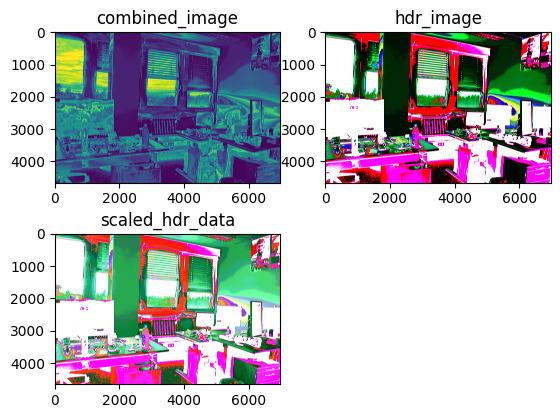

In [80]:
plot_image(combined_image,2,2,1,title="combined_image")
plot_image(scaled_hdr_data,2,2,3,title="scaled_hdr_data")
plot_image(hdr_image,2,2,2,title="hdr_image")
plt.show()

task 7(iCAM06)

In [72]:
output_directory = '/Users/pankajrathi/Projcv/exercise2'
output_filename = 'scaled_hdr_image.jpg'
os.makedirs(output_directory, exist_ok=True)
output_path = os.path.join(output_directory, output_filename)
imageio.imwrite(output_path, scaled_hdr_data, format='JPEG')

print(f"Image saved to: {output_path}")

Image saved to: /Users/pankajrathi/Projcv/exercise2/scaled_hdr_image.jpg


In [81]:
def iCAM06_HDR(image, sigma_s,sigma_r, output_range):
    # Calculate input_intensity
    input_intensity = (1 / 61) * (20 * image[:, :, 0] + 40 * image[:, :, 1] + image[:, :, 2])

    # Normalize RGB
    r, g, b = image[:, :, 0] / input_intensity, image[:, :, 1] / input_intensity, image[:, :, 2] / input_intensity

    # Calculate log_base using bilateral filter
    log_base = restoration.denoise_bilateral(np.log(input_intensity),win_size= 9,sigma_color= sigma_r,sigma_spatial = sigma_s )

    # Calculate log_details
    log_details = np.log(input_intensity) - log_base

    # Calculate compression factor
    compression = np.log(output_range) / (np.max(log_base) - np.min(log_base))

    # Calculate log_offset
    log_offset = -np.max(log_base) * compression

    # Calculate output_intensity
    output_intensity = np.exp(log_base * compression + log_offset + log_details)

    # Scale the RGB values
    r_output, g_output, b_output = r * output_intensity, g * output_intensity, b * output_intensity

    # Stack the channels to get the final HDR image
    hdr_image = np.stack([r_output, g_output, b_output], axis=-1)

    return hdr_image

In [82]:
image = io.imread('/Users/pankajrathi/Projcv/exercise_2_data/scaled_hdr_image.jpg')

# Set the parameters
sigma_r = 1.3  # Adjust as needed
sigma_s = 0.9  # Adjust as needed
output_range = 4  # Adjust as needed
# img_as_float
# Call the iCAM06_HDR function
hdr_result = iCAM06_HDR(img_as_float(image), sigma_s, sigma_r,output_range)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


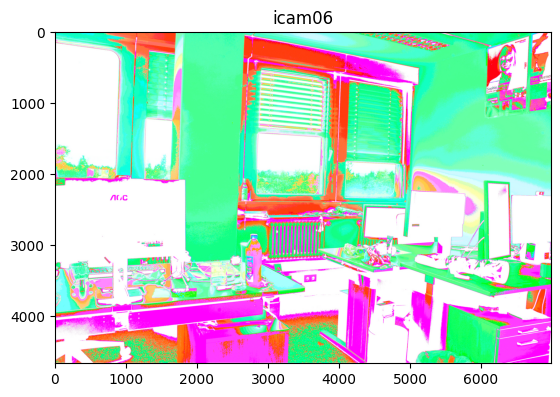

In [83]:
plt.title('icam06')
plt.imshow(hdr_result)
plt.show()